# Data Description of the Satellite Observations

In this dataset a number of remote sensing variables are provided to estimate a soil moisture index on a global scale. 
This dataset comes from the Remote Sensing exercise developed by Jana Kolassa and Filipe Aires in the context of
the GreenCycles II ETN Network. 

Libraries we need to structure and plot the data are imported first

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import xarray as xr
from scipy.interpolate import griddata
from scipy import interpolate
import statsmodels.api as sm
from matplotlib.ticker import EngFormatter, StrMethodFormatter
import geopandas as gp

Data used in this exercise is stored in the DATA folder

In [162]:
thefile = '../../../DATA/TPdata_199301'

## Create and Format a Dataframe

The dataframe is created using the .read_csv function of Pandas

In [165]:
data = pd.read_csv(thefile, sep='\t', header=None)
data

,0,1,2,3,4,5,6,7,8
0,1.0,-89.875,-60.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,-89.875,60.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,-89.875,180.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,-89.625,-20.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,-89.625,20.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
660061,660062.0,89.625,-100.0,NaN,NaN,NaN,NaN,NaN,NaN
660062,660063.0,89.625,-60.0,NaN,NaN,NaN,NaN,NaN,NaN
660063,660064.0,89.875,-60.0,NaN,NaN,NaN,NaN,NaN,NaN
660064,660065.0,89.875,60.0,NaN,NaN,NaN,NaN,NaN,NaN


The original CSV file is structured as a dataframe with the corresponding categories

In [73]:
data.columns = ["cellNr", "latitude", "longitude", "backscatter","emissivity_v","emissivity_h","ts_amplitude","ndvi","lmd_soilWetness"]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660066 entries, 0 to 660065
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   cellNr           660066 non-null  float64
 1   latitude         660066 non-null  float64
 2   longitude        660066 non-null  float64
 3   backscatter      660066 non-null  object 
 4   emissivity_v     660066 non-null  object 
 5   emissivity_h     660066 non-null  object 
 6   ts_amplitude     660066 non-null  object 
 7   ndvi             660066 non-null  object 
 8   lmd_soilWetness  660066 non-null  object 
dtypes: float64(3), object(6)
memory usage: 45.3+ MB


We assign a NaN value to all the inputs with the string "Nan" in the original data file 

In [75]:
data = data.replace('   NaN',pd.NA)
data

,cellNr,latitude,longitude,backscatter,emissivity_v,emissivity_h,ts_amplitude,ndvi,lmd_soilWetness
0,1.0,-89.875,-60.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2.0,-89.875,60.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,3.0,-89.875,180.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,4.0,-89.625,-20.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,5.0,-89.625,20.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...
660061,660062.0,89.625,-100.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
660062,660063.0,89.625,-60.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
660063,660064.0,89.875,-60.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
660064,660065.0,89.875,60.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


We now assign a numeric data type to all the object types where the remote sensing variables are stored

In [77]:
data['backscatter'] = pd.to_numeric(data['backscatter'])
data['emissivity_v'] = pd.to_numeric(data['emissivity_v'])
data['emissivity_h'] = pd.to_numeric(data['emissivity_h'])
data['ts_amplitude'] = pd.to_numeric(data['ts_amplitude'])
data['ndvi'] = pd.to_numeric(data['ndvi'])
data['lmd_soilWetness'] = pd.to_numeric(data['lmd_soilWetness'])

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660066 entries, 0 to 660065
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   cellNr           660066 non-null  float64
 1   latitude         660066 non-null  float64
 2   longitude        660066 non-null  float64
 3   backscatter      79159 non-null   float64
 4   emissivity_v     81070 non-null   float64
 5   emissivity_h     81070 non-null   float64
 6   ts_amplitude     55681 non-null   float64
 7   ndvi             81137 non-null   float64
 8   lmd_soilWetness  68982 non-null   float64
dtypes: float64(9)
memory usage: 45.3 MB


## Basic Statistics

Basic statistics are provided by the .describe() method within pandas dataframes. 

In [82]:
data.describe()

,cellNr,latitude,longitude,backscatter,emissivity_v,emissivity_h,ts_amplitude,ndvi,lmd_soilWetness
count,660066.000000,660066.000000,660066.000000,79159.000000,81070.000000,81070.000000,55681.000000,81137.000000,68982.000000
mean,330033.500000,0.000000,0.084537,-11.809665,0.966447,0.911618,24.035404,0.341698,0.479404
std,190544.785729,39.171964,103.923274,3.688083,0.017271,0.047736,11.089443,0.223595,0.227891
min,1.000000,-89.875000,-180.000000,-27.228800,0.687300,0.389900,1.327500,-0.031400,0.000000
25%,165017.250000,-30.125000,-89.923100,-13.718550,0.956700,0.872800,14.552900,0.124000,0.277300
50%,330033.500000,0.000000,0.132500,-10.855700,0.965800,0.927400,24.135700,0.301100,0.426850
75%,495049.750000,30.125000,90.079200,-9.054200,0.976300,0.949100,31.874400,0.565000,0.644800
max,660066.000000,89.875000,180.000000,-5.485400,1.034200,1.010900,62.281600,0.794700,1.011300


## Create a Grid

Data is structured as columns, but ideally we would like to have them as an array of arrays, creating a meshgrid that we can plot on a map. To this end, we extract the values of each column first. 

In [91]:
back = data['backscatter'].values
lats = data['latitude'].values
lons = data['longitude'].values
emissivity_v = data['emissivity_v'].values
emissivity_h = data['emissivity_h'].values
ts_amplitude = data['ts_amplitude'].values
ndvi = data['ndvi'].values
lmd_soilWetness = data['lmd_soilWetness'].values

Then we use the latitude and longitude to create the meshgrid at low resolution for this exercise

In [94]:
Yi = np.linspace(np.min(lats.data),float(np.max(lats.data)),180)
Xi = np.linspace(np.min(lons.data),float(np.max(lons.data)),360)
X, Y = np.meshgrid(Xi,Yi)
points = list(zip(lons, lats))

Now we assign every data point to each lat,lon pair using the griddata function. 

In [98]:
back_gridded = griddata(points, back, (X, Y), method='nearest')
emissivity_v_gridded = griddata(points, emissivity_v, (X, Y), method='nearest')
emissivity_h_gridded = griddata(points, emissivity_h, (X, Y), method='nearest')
ts_amplitude_gridded = griddata(points, ts_amplitude, (X, Y), method='nearest')
ndvi_gridded = griddata(points, ndvi, (X, Y), method='nearest')
lmd_soilWetness_gridded = griddata(points, lmd_soilWetness, (X, Y), method='nearest')

## Plot Variables

For plotting the variables on a map using matplotlib we first import the coastal contour lines from the entire world in SHP format. 

In [172]:
world = gp.read_file('../../../DATA/ne_10m_coastline.shp')

### Backscatter

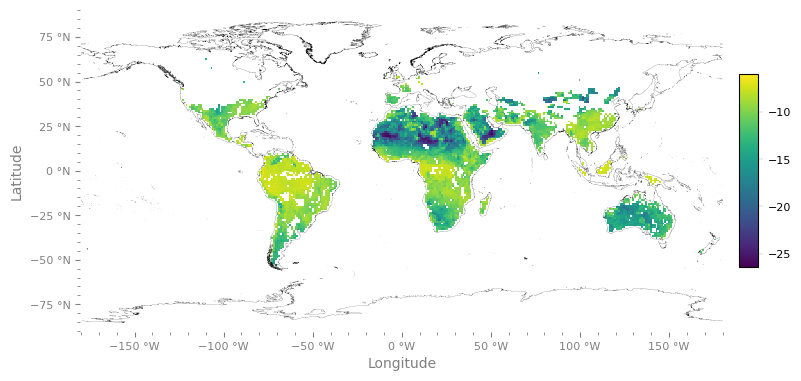

In [184]:
fig,ax = pl.subplots(figsize=(10, 5))
mesh = ax.pcolormesh(X,Y,back_gridded);
ax.set_xlabel('Longitude', fontsize=10,linespacing=1, color='grey')
ax.set_ylabel('Latitude', fontsize=10, color='grey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=8, colors='grey')
ax.tick_params(axis='both', which='minor', labelsize=8, colors='grey')
ax.yaxis.set_major_formatter(EngFormatter(unit=u"°N"))
ax.xaxis.set_major_formatter(EngFormatter(unit=u"°W"))
world.plot(ax=ax, facecolor='none',edgecolor='black',linewidth=0.1);
cbar = pl.colorbar(mesh, ax=ax, shrink=.5, pad=.02, aspect=10)
cbar.ax.tick_params(labelsize=8, width=0.1) 

### Emissivity - Horizontal

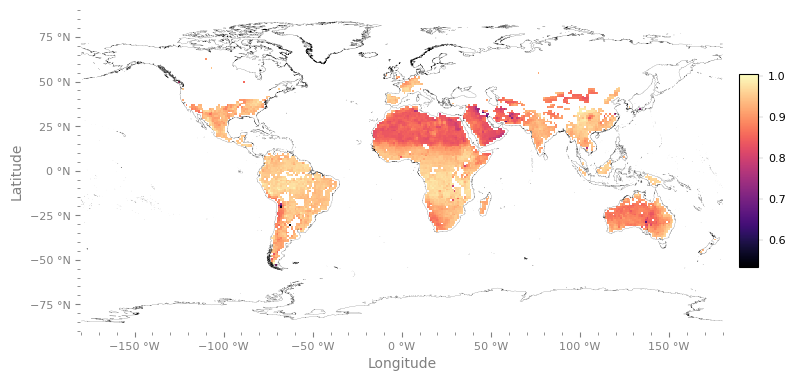

In [186]:
fig,ax = pl.subplots(figsize=(10, 5))
mesh = ax.pcolormesh(X,Y,emissivity_h_gridded, cmap='magma');
ax.set_xlabel('Longitude', fontsize=10,linespacing=1, color='grey')
ax.set_ylabel('Latitude', fontsize=10, color='grey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=8, colors='grey')
ax.tick_params(axis='both', which='minor', labelsize=8, colors='grey')
ax.yaxis.set_major_formatter(EngFormatter(unit=u"°N"))
ax.xaxis.set_major_formatter(EngFormatter(unit=u"°W"))
world.plot(ax=ax, facecolor='none',edgecolor='black',linewidth=0.1);
cbar = pl.colorbar(mesh, ax=ax, shrink=.5, pad=.02, aspect=10)
cbar.ax.tick_params(labelsize=8, width=0.1) 

### Emissivity - Vertical

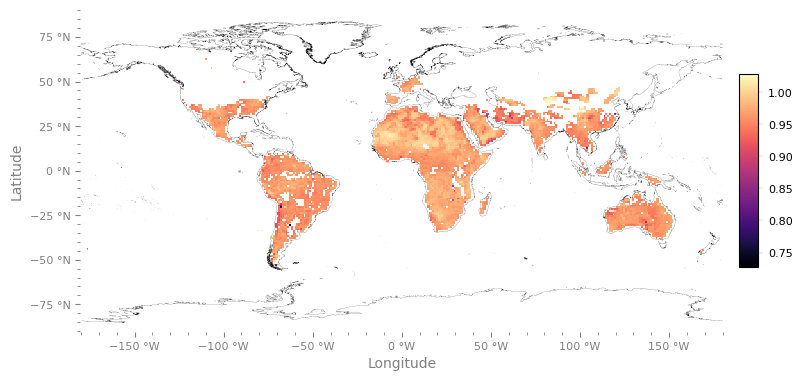

In [188]:
fig,ax = pl.subplots(figsize=(10, 5))
mesh = ax.pcolormesh(X,Y,emissivity_v_gridded, cmap='magma');
ax.set_xlabel('Longitude', fontsize=10,linespacing=1, color='grey')
ax.set_ylabel('Latitude', fontsize=10, color='grey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=8, colors='grey')
ax.tick_params(axis='both', which='minor', labelsize=8, colors='grey')
ax.yaxis.set_major_formatter(EngFormatter(unit=u"°N"))
ax.xaxis.set_major_formatter(EngFormatter(unit=u"°W"))
world.plot(ax=ax, facecolor='none',edgecolor='black',linewidth=0.1);
cbar = pl.colorbar(mesh, ax=ax, shrink=.5, pad=.02, aspect=10)
cbar.ax.tick_params(labelsize=8, width=0.1)

### Surface Temperature Amplitude

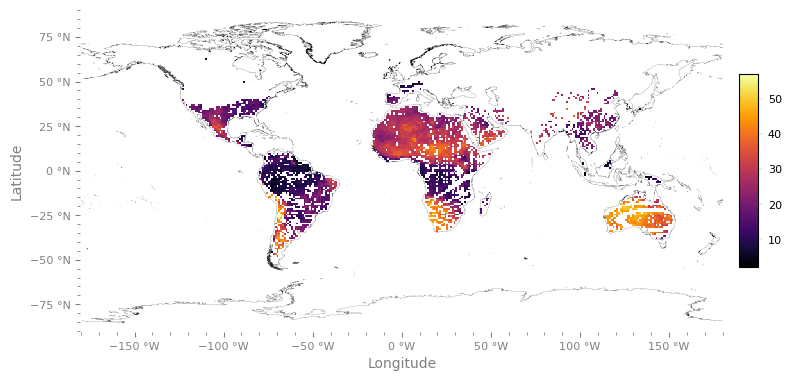

In [190]:
fig,ax = pl.subplots(figsize=(10, 5))
mesh = ax.pcolormesh(X,Y,ts_amplitude_gridded, cmap='inferno');
ax.set_xlabel('Longitude', fontsize=10,linespacing=1, color='grey')
ax.set_ylabel('Latitude', fontsize=10, color='grey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=8, colors='grey')
ax.tick_params(axis='both', which='minor', labelsize=8, colors='grey')
ax.yaxis.set_major_formatter(EngFormatter(unit=u"°N"))
ax.xaxis.set_major_formatter(EngFormatter(unit=u"°W"))
world.plot(ax=ax, facecolor='none',edgecolor='black',linewidth=0.1);
cbar = pl.colorbar(mesh, ax=ax, shrink=.5, pad=.02, aspect=10)
cbar.ax.tick_params(labelsize=8, width=0.1)

### NDVI

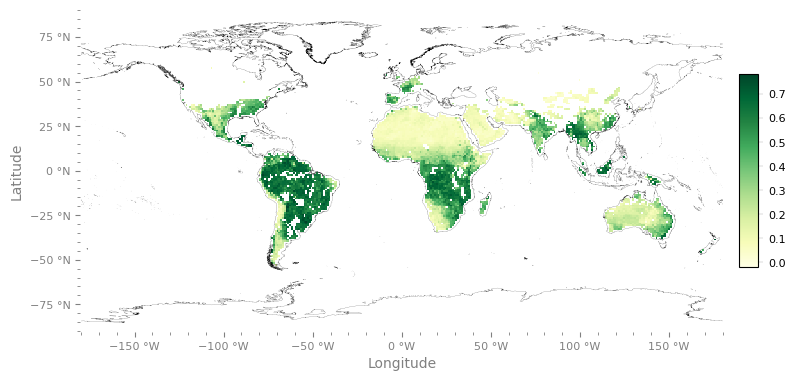

In [192]:
fig,ax = pl.subplots(figsize=(10, 5))
mesh = ax.pcolormesh(X,Y,ndvi_gridded, cmap='YlGn');
ax.set_xlabel('Longitude', fontsize=10,linespacing=1, color='grey')
ax.set_ylabel('Latitude', fontsize=10, color='grey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=8, colors='grey')
ax.tick_params(axis='both', which='minor', labelsize=8, colors='grey')
ax.yaxis.set_major_formatter(EngFormatter(unit=u"°N"))
ax.xaxis.set_major_formatter(EngFormatter(unit=u"°W"))
world.plot(ax=ax, facecolor='none',edgecolor='black',linewidth=0.1);
cbar = pl.colorbar(mesh, ax=ax, shrink=.5, pad=.02, aspect=10)
cbar.ax.tick_params(labelsize=8, width=0.1)

### LMD Soil Moisture Index

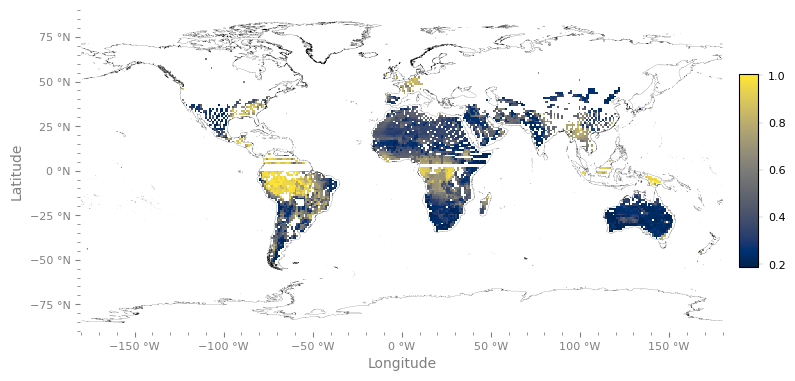

In [194]:
fig,ax = pl.subplots(figsize=(10, 5))
mesh = ax.pcolormesh(X,Y,lmd_soilWetness_gridded, cmap='cividis');
ax.set_xlabel('Longitude', fontsize=10,linespacing=1, color='grey')
ax.set_ylabel('Latitude', fontsize=10, color='grey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=8, colors='grey')
ax.tick_params(axis='both', which='minor', labelsize=8, colors='grey')
ax.yaxis.set_major_formatter(EngFormatter(unit=u"°N"))
ax.xaxis.set_major_formatter(EngFormatter(unit=u"°W"))
world.plot(ax=ax, facecolor='none',edgecolor='black',linewidth=0.1);
cbar = pl.colorbar(mesh, ax=ax, shrink=.5, pad=.02, aspect=10)
cbar.ax.tick_params(labelsize=8, width=0.1)